<a href="https://colab.research.google.com/github/Brighton94/pneumonia-detection-with-deeplearning/blob/main/pneumonia_detection_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection from Chest X-ray Images with Deep Learning
Brighton Nkomo

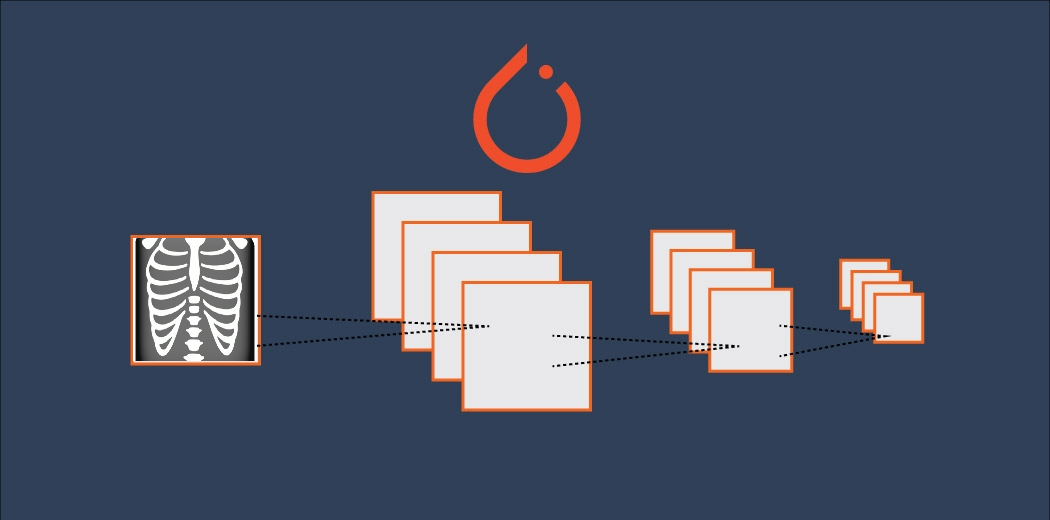

# Description

The data is obtained from [Mendely Data](https://data.mendeley.com/datasets/rscbjbr9sj/2), which is a secure cloud-based repository where you can store your data, ensuring it is easy to share, access and cite, wherever you are. Usually research data is stored there.

I will be looking at a dataset of validated OCT and Chest X-Ray images  described and analyzed in "Deep learning-based classification and referral of treatable human diseases". The OCT Images are split into a training set and a testing set of independent patients. OCT Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

# Data Preperation

In [1]:
# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import cv2
import os

I will use the Computer Unified Device Architecture, which enables the use of NVIDIA GPUs for computational tasks (in my case, training CNNs in PyTorch). 

The `.is_available()` method basically checks if CUDA is available, if it is then the value returned would be `True`.

In [2]:
# CUDA

torch.cuda.is_available()

True

In [3]:
# Set up the GPU
device = torch.device('cuda:0')

Define the function `plot_channels` to plot out the kernel parameters of  each channel

In [4]:
# Define the function for plotting the channels

def plot_channels(W):
    W = W.cpu()
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

Define the function `plot_parameters` to plot out the kernel parameters of each channel with Multiple outputs.

In [5]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :].cpu()
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

Define the function `plot_activation` to plot out the activations of the Convolutional layers

In [6]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.9)    

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

# Loading, Reading and Transforming the Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd /content/drive/My Drive/chest_xray

/content/drive/My Drive/chest_xray


We create a transform to resize the image and convert it to a tensor.

In [9]:
# Converting image to a tensor and data augmentation

transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])}

Load the training dataset by setting the parameter `train` to `True`. We use the transform defined above.

In [10]:
trainset = dsets.ImageFolder('train',transform = transformers['train_transforms'])
testset = dsets.ImageFolder('test',transform = transformers['test_transforms'])

In [11]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

In [12]:
class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


Let's see how much data is in the train and test set.

In [13]:
print('Number of images in the train set:',len(trainset))
print('Number of images in the test set:',len(testset))

Number of images in the train set: 5242
Number of images in the test set: 624


I could say, print out the label for the fourth data element

In [14]:
trainset[3][1]

0

Let's visualise the images (16 of them)

tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])


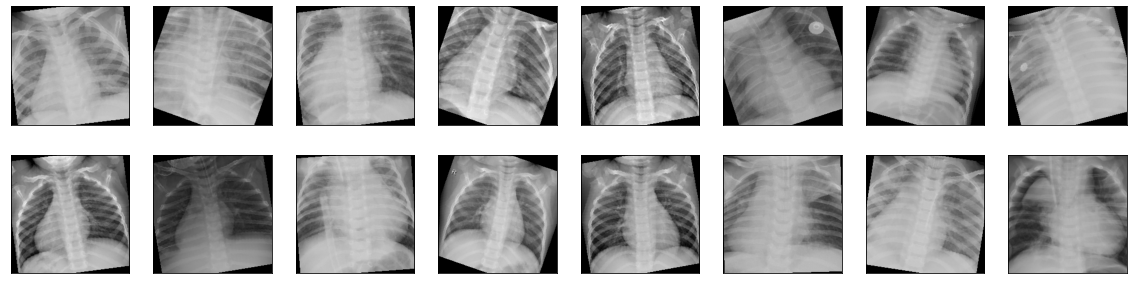

In [15]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)));
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(20,5))

for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[]);
    imshow(images[idx]);
print(labels) 

The x-ray images are not black and white images, even though they appear to be. I will use the OpenCV library to load the image and prove that.

In [16]:
my_image = "x-ray.jpeg"
cwd = os.getcwd()
image_path = os.path.join(cwd, my_image)
image_path

'/content/drive/My Drive/chest_xray/x-ray.jpeg'

In [17]:
image = cv2.imread(my_image)

In [18]:
len(image.shape)

3

The 3 above represents the number of channels. So, the images are RGB channels. If the sample x-ray image was black and white, then the value would be 1 and not 3.

# Model Building 

I will now build a convolutional network class with two vonvolutional layers and one fully connected layer.

Here are a few things to note before proceeding:
- Channel Width can be calculated using the following formula, which is a screenshot taken from the [PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)

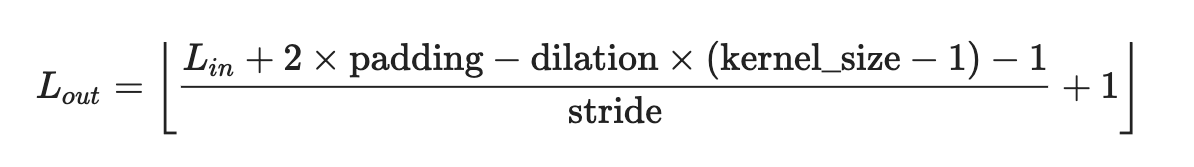

Also note these default values for the CNN layer and max pool layer in particular:

- stride (int or tuple, optional) – Stride of the convolution. Default: 1 (Note that _the default value is the kernel size for the max pooling layer_).

- padding (int, tuple or str, optional) – Padding added to both sides of the input. Default: 0

- dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1

In [19]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        # The reason we start with 3 channel is because the image is RGB not black and white
        # Channel Width after this layer is 220
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=0)
        # Channel Width after this layer is 110
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        # Channel Width after this layer is 106 actually
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=0)
        # Channel Width after this layer is 53
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        # In total we have out_2 (32) channels which are each 53 * 53 in size based on the width calculation above. Channels are squares.
        # The output is a value for each class
        self.fc1 = nn.Linear(out_2 * 53 * 53, 2)
    
    # Prediction
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs result of each stage of the CNN, relu, and pooling layers
    def activations(self, x):
        # Outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

In [20]:
# Create the model object using CNN class

model = CNN(out_1=16, out_2=32)

# Send the model class to the GPU
model.to(device)

CNN(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=2, bias=True)
)

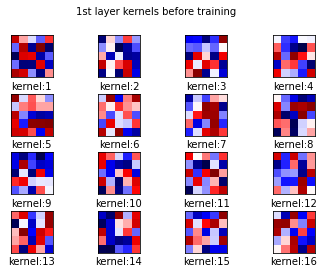

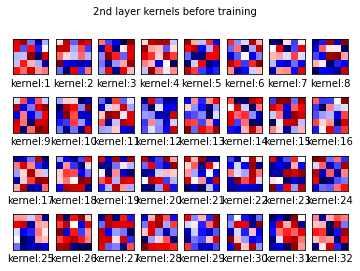

In [21]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

# Model Training

In [22]:
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [23]:
# Train the model

# Number of times we want to train on the taining dataset
n_epochs=3
# List to keep track of cost and accuracy
cost_list=[]
accuracy_list=[]
# Size of the test dataset
N_test=len(testset)

# Model Training Function
def train_model(n_epochs):
    # Loops for each epoch
    for epoch in range(n_epochs):
        # Keeps track of cost for each epoch
        COST=0
        # For each batch in train loader
        for x, y in trainloader:
            # Send the train features and labels to the GPU
            x, y = x.to(device), y.to(device)
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on X value
            z = model(x)
            # Measures the loss between prediction and acutal Y value
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
            # Cumulates loss 
            COST+=loss.data
        
        # Saves cost of training data of epoch
        cost_list.append(COST)
        # Keeps track of correct predictions
        correct=0
        # Perform a prediction on the validation  data  
        for x_test, y_test in testloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            # Makes a prediction
            z = model(x_test)
            # The class with the max value is the one we are predicting
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual value
            correct += (yhat == y_test).sum().item()
        
        # Calcualtes accuracy and saves it
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
train_model(n_epochs)

# Analyzing the Results

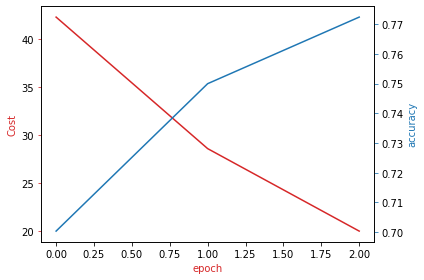

In [24]:
# Plot the Loss and Accuracy vs Epoch graph

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

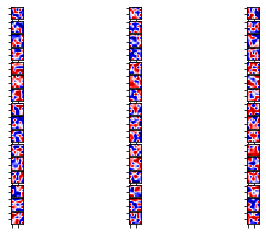

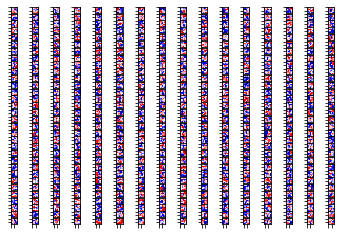

In [25]:
# Plot the channels

plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

# Conclusion

In [29]:
print("The accuracy of the CNN model is: {:.2f} ".format(accuracy_list[-1]))

The accuracy of the CNN model is: 0.77 
